In [2]:
%pylab inline
from __future__ import print_function
import os
import numpy as np

Populating the interactive namespace from numpy and matplotlib


##Model background
Here is an example based on the Henry saltwater intrusion problem.  The synthetic model is a 2-dimensional SEAWAT model (X-Z domain) with 1 row, 120 columns and 20 layers.  The left boundary is a specified flux of freshwater, the right boundary is a specified head and concentration saltwater boundary.  The model has two stress periods: an initial steady state (calibration) period, then a transient period with less flux (forecast).  

<img src="henry/domain.png" width=800/>

The inverse problem has 603 parameters: 600 hydraulic conductivity pilot points, 1 global hydraulic conductivity, 1 specified flux multiplier for history matching and 1 specified flux multiplier for forecast conditions.  The inverse problem has 36 obseravtions (21 heads and 15 concentrations) measured at the end of the steady-state calibration period.  Additional, zero-weight observations of head and concentration are also available at each observation location at the end of the transient forecast period as is the distance from the left edge of the domain to the 1%, 10% and 50% saltwater contours in the basal model layer at the end of the forecast stress period.  These distances, named ```pd_one```, ```pd_ten``` and ```pd_half``` are the forecasts we are interested in.  I previously calculated the jacobian matrix, which is in the `henry/` folder, along with the PEST control file.



##Using `pyemu`

In [3]:
import pyemu

First create a linear_analysis object.  We will use `schur`  derived type, which replicates the behavior of the `PREDUNC` suite of PEST.  We pass it the name of the jacobian matrix file.  Since we don't pass an explicit argument for `parcov` or `obscov`, `pyemu` attempts to build them from the parameter bounds and observation weights in a pest control file (.pst) with the same base case name as the jacobian.  Since we are interested in forecast uncertainty as well as parameter uncertainty, we also pass the names of the forecast sensitivity vectors we are interested in, which are stored in the jacobian as well.  Note that the `forecasts` argument can be a mixed list of observation names, other jacobian files or PEST-compatible ASCII matrix files.

In [4]:
forecasts = ["pd_one","pd_ten","pd_half"]
la = pyemu.schur(jco=os.path.join("henry", "pest.jcb"), forecasts=forecasts)


2015-05-05 16:13:50.386974 starting: pre-loading base components

2015-05-05 16:13:50.387070 starting: loading jco: henry/pest.jcb

2015-05-05 16:13:50.396613 finished: loading jco: henry/pest.jcb took: 0:00:00.009543

2015-05-05 16:13:50.396692 starting: loading pst: henry/pest.pst

2015-05-05 16:13:50.406918 finished: loading pst: henry/pest.pst took: 0:00:00.010226

2015-05-05 16:13:50.406977 starting: loading parcov

2015-05-05 16:13:50.485595 finished: loading parcov took: 0:00:00.078618

2015-05-05 16:13:50.486030 starting: loading obscov

2015-05-05 16:13:50.502173 finished: loading obscov took: 0:00:00.016143

2015-05-05 16:13:50.502240 starting: loading forecasts

2015-05-05 16:13:50.511004 finished: loading forecasts took: 0:00:00.008764

2015-05-05 16:13:50.511060 finished: pre-loading base components took: 0:00:00.124086

2015-05-05 16:13:50.511082 starting: dropping prior information

2015-05-05 16:13:50.511145 starting: removing 601 prior info from jco, pst, and obs cov



/Users/jwhite/Development/python/pyemu/pst_handler.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  obs.weight[idxs] = obs.weight[idxs] * factor


The screen output can be redirected to a log file by passing a file name to the `verbose` keyword argument.  Or screen output can be stopped by passing `False` to the `verbose` argument

In [5]:
la = pyemu.schur(jco=os.path.join("henry", "pest.jcb"), forecasts=forecasts,verbose=False)
obs_names = la.pst.obs_names
[obs_names.remove(name) for name in ["pd_one","pd_ten","pd_half"]]
la = la.get(par_names=la.pst.par_names,obs_names=obs_names)

We can inspect the parcov and obscov attributes by saving them to files.  We can save them PEST-compatible ASCII or binary matrices (`.to_ascii()` or `.to_binary()`), PEST-compatible uncertainty files (`.to_uncfile()`), or simply as numpy ASCII arrays (`numpy.savetxt()`).  In fact, all matrix and covariance objects (including the forecasts) have these methods.  


In [6]:
la.parcov.to_uncfile(os.path.join("henry", "parcov.unc"), covmat_file=os.path.join("henry","parcov.mat"))

When saving an uncertainty file, if the covariance object is diagonal (`self.isdiagonal == True`), then you can force the uncertainty file to use standard deviation blocks instead of covariance matrix blocks by explicitly passing `covmat_file` as `None`:

In [7]:
la.obscov.to_uncfile(os.path.join("henry", "obscov.unc"), covmat_file=None)

##Posterior parameter uncertainty analysis
Let's calculate and save the posterior parameter covariance matrix:

In [8]:
la.posterior_parameter.to_ascii(os.path.join("henry", "posterior.mat"))

You can open this file in a text editor to examine.  The diagonal of this matrix is the posterior variance of each parameter. Since we already calculated the posterior parameter covariance matrix, additional calls to the `posterior_parameter` decorated method only require access:


In [9]:
la.posterior_parameter.to_dataframe() #look so nice in the notebook

,global_k,mult1,mult2,kr01c01,kr01c02,kr01c03,kr01c04,kr01c05,kr01c06,kr01c07,...,kr10c51,kr10c52,kr10c53,kr10c54,kr10c55,kr10c56,kr10c57,kr10c58,kr10c59,kr10c60
global_k,1.732213e-03,1.325684e-03,8.199739e-64,8.844501e-08,1.601854e-06,-3.547648e-06,-9.452774e-06,-3.533647e-05,-7.182657e-05,-9.500101e-05,...,-4.663594e-05,1.545253e-05,4.748255e-05,1.798866e-05,-1.839573e-04,-4.371738e-04,-4.249806e-04,-3.253683e-04,-2.373091e-04,-1.441270e-04
mult1,1.325684e-03,1.707831e-03,9.923818e-64,-8.014284e-08,-1.783284e-06,3.963599e-06,1.045543e-05,3.885385e-05,7.881330e-05,1.043162e-04,...,3.323354e-04,3.220377e-04,2.600914e-04,1.130884e-04,-1.611394e-04,-4.260098e-04,-4.479738e-04,-3.835346e-04,-3.180449e-04,-2.117039e-04
mult2,8.199739e-64,9.923818e-64,1.422779e-02,-4.658094e-68,-5.604953e-67,1.212588e-66,3.449374e-66,1.316867e-65,2.697148e-65,3.556441e-65,...,4.327570e-63,4.923596e-63,4.561275e-63,3.665491e-63,1.814012e-63,-9.866664e-66,-4.166848e-66,4.605961e-64,8.613709e-64,7.710841e-64
kr01c01,8.844501e-08,-8.014284e-08,-4.658094e-68,2.499981e-01,-4.861151e-06,-6.816126e-06,-7.314446e-06,-2.990854e-06,4.226964e-06,7.584155e-06,...,2.400952e-07,-2.151251e-07,-1.621010e-07,-6.549911e-08,5.606735e-08,1.502410e-07,6.570224e-07,1.624622e-07,1.473219e-07,1.022951e-07
kr01c02,1.601854e-06,-1.783284e-06,-5.604953e-67,-4.861151e-06,2.499876e-01,-1.735110e-05,-1.870345e-05,-8.359758e-06,8.792683e-06,1.676032e-05,...,8.582012e-07,-1.299859e-07,5.708701e-08,-1.757643e-07,-1.301964e-06,-2.459839e-06,-1.323881e-06,-1.896856e-06,-1.418807e-06,-1.081844e-06
kr01c03,-3.547648e-06,3.963599e-06,1.212588e-66,-6.816126e-06,-1.735110e-05,2.499753e-01,-2.682993e-05,-1.352113e-05,8.765312e-06,1.879910e-05,...,1.427607e-06,-9.568069e-07,-1.249025e-06,-5.149297e-07,2.239276e-06,5.763656e-06,7.175513e-06,4.551889e-06,3.463143e-06,1.845375e-06
kr01c04,-9.452774e-06,1.045543e-05,3.449374e-66,-7.314446e-06,-1.870345e-05,-2.682993e-05,2.499702e-01,-1.811893e-05,1.865403e-06,1.052483e-05,...,2.728998e-06,-9.530747e-07,-1.946944e-06,-5.945276e-07,5.677351e-06,1.364445e-05,1.500584e-05,1.055830e-05,7.915095e-06,4.463403e-06
kr01c05,-3.533647e-05,3.885385e-05,1.316867e-65,-2.990854e-06,-8.359758e-06,-1.352113e-05,-1.811893e-05,2.499719e-01,-4.212408e-05,-5.061088e-05,...,7.568039e-06,-2.198182e-07,-4.430920e-06,-7.211216e-07,2.038879e-05,4.729373e-05,4.674720e-05,3.604455e-05,2.671581e-05,1.546721e-05
kr01c06,-7.182657e-05,7.881330e-05,2.697148e-65,4.226964e-06,8.792683e-06,8.765312e-06,1.865403e-06,-4.212408e-05,2.498899e-01,-1.456635e-04,...,1.478763e-05,1.358980e-06,-7.524192e-06,-8.879298e-07,4.042210e-05,9.356867e-05,8.986874e-05,7.091570e-05,5.233868e-05,3.016490e-05
kr01c07,-9.500101e-05,1.043162e-04,3.556441e-65,7.584155e-06,1.676032e-05,1.879910e-05,1.052483e-05,-5.061088e-05,-1.456635e-04,2.498050e-01,...,1.842088e-05,1.296293e-06,-1.035671e-05,-1.236642e-06,5.408133e-05,1.249087e-04,1.195595e-04,9.481506e-05,7.006086e-05,4.058817e-05


We can see the posterior variance of each parameter along the diagonal of this matrix. Now, let's make a simple plot of prior vs posterior uncertainty for the 600 pilot point parameters

,percent_reduction,post_var,prior_var
global_k,43.687181,0.001732,0.003076
mult1,44.479814,0.001708,0.003076
mult2,0.000000,0.014228,0.014228
kr01c01,0.000778,0.249998,0.250000
kr01c02,0.004945,0.249988,0.250000
kr01c03,0.009863,0.249975,0.250000
kr01c04,0.011907,0.249970,0.250000
kr01c05,0.011229,0.249972,0.250000
kr01c06,0.044057,0.249890,0.250000
kr01c07,0.077997,0.249805,0.250000


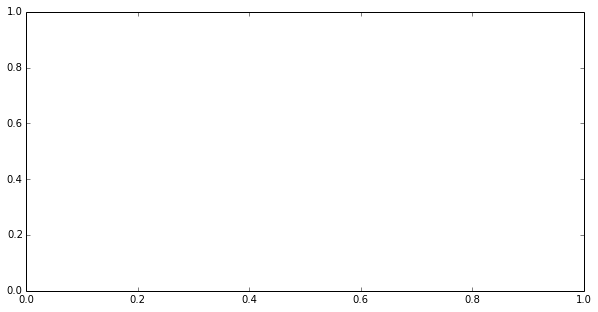

In [16]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
par_sum = la.get_parameter_summary()
par_sum

We can see that the at most, the uncertainty of any one of the 600 hydraulic conductivity parameters is only reduced by 5% and the uncertainty of many parameters has not been reduced at all, meaning these parameters are not informed by the observations.  

##Prior forecast uncertainty
Now let's examine the prior variance of the forecasts:

In [20]:
prior = la.prior_forecast
print(prior) # dict keyed on forecast name


{'pd_half': 3.5133025343000108, 'pd_ten': 4.3999869680441748, 'pd_one': 3.4924718146850973}


Sometimes, it is more intuitive to think in terms of standard deviation, which in this case has units of ```meters``` and can be thought of as the "+/-" around the model-predicted distance from the left edge of the domain to the three saltwater concentration contours

In [21]:
for pname,var in la.prior_forecast.items():
    print(pname,np.sqrt(var))

pd_half 1.8743805735
pd_ten 2.09761458997
pd_one 1.86881561816


##Posterior forecast uncertainty
Now, let's calculate the posterior uncertainty (variance) of each forecast:

In [22]:
post = la.posterior_forecast
for pname,var in post.items():
    print(pname,np.sqrt(var))

pd_half 1.22791179046
pd_ten 1.34251133524
pd_one 1.20746990091


That's it - we have completed linear-based uncertainty analysis for a model with 603 parameters and we completed it before actual inversion so we can estimate the worth of continuing and actually completing the expense inversion process!  We can see that the data we have provide atleast some conditioning to each of these forecasts, indicating that the history-matching process is valuable:

In [19]:
la.get_forecast_summary()

,percent_reduction,post_var,prior_var
pd_half,57.084044,1.507767,3.513303
pd_ten,59.037681,1.802337,4.399987
pd_one,58.253534,1.457984,3.492472


It is interesting that the uncertainty of the forecasts is reduced substantially even though the uncertainty for any one parameter is only slightly reduced.  This is because the right combinations of forecast-sensitive parameters are being informed by the observations.

##Data worth
Now, let's try to identify which observations are most important to reducing the posterior uncertainty (e.g.the forecast worth of every observation).  We simply recalculate Schur's complement without some observations and see how the posterior forecast uncertainty increases


```importance_of_obesrvation_groups()``` is a thin wrapper that calls the underlying ```importance_of_observations()``` method using the observation groups in the pest control file and stacks the results into a ```pandas DataFrame```.  

lets see if the heads or the concentrations are more important:

In [ ]:
df = la.importance_of_observation_groups()
df

```base``` row are the results of Schur's complement calculation using all observations.  The increase in posterior forecast uncertainty for the ```head``` and ```conc``` cases show how much forecast uncertainty increases when the head and concentrations observations are not used in history matching

So, it looks like the heads and concentrations are both important for reducing the posterior uncertainty of the forecasts. 

##parameter contribution to uncertainty
Lets look at which parameters are contributing most to forecast uncertainty.  for demostration purposes, lets group the hydraulic conductivity parameters by row.

In [ ]:
par_groups = {}
for pname in la.pst.par_names:
    if pname.startswith('k'):
        row = "k_row_"+pname[2:4]
        if row not in par_groups.keys():
            par_groups[row] = []
        par_groups[row].append(pname)

par_groups["global_k"] = "global_k"
par_groups["histmatch_mult"] = "mult1"
par_groups["forecast_mult"] = "mult2"
df = la.get_contribution_dataframe(par_groups)
df

We see that the largest contributions to forecast uncertainty depends on the forecast. Forecast ```pd_half``` is most sensitive to hydraulic conductivity parameters in row 10.  However, Forecasts ```pd_one``` and ```pd_ten``` are most sensitive to the ```global_k``` parameter.